In this example we will fetch historic timeseries data for a location using concurrent requests for increased speed.

It is important to note that it is possible to exceed your rate limit as you increase the number of parallel downloads, which may cause some requests to fail!

In [1]:
# ! pip install pandas matplotlib

In [2]:
import concurrent.futures

import pandas as pd

from solcast.unmetered_locations import UNMETERED_LOCATIONS
from solcast import historic

In [3]:
site = UNMETERED_LOCATIONS["Stonehenge"]
latitude, longitude = site["latitude"], site["longitude"]
latitude, longitude

(51.178882, -1.826215)

In [4]:
# /data/historic/radiation_and_weather returns up to 31 days data, so each request should be one month
months = pd.date_range("2022-01-01", "2023-01-01", freq="MS")
months

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [5]:
# make API calls
futures = []
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as pool:
    for start, end in zip(months[:-1], months[1:]):
        f = pool.submit(
            historic.radiation_and_weather,
            latitude=latitude,
            longitude=longitude,
            start=start,
            end=end,
            output_parameters=["ghi", "dni"],
            period="PT60M"
        )
        futures.append(f)

# read API responses
df = []
for f in futures:
    res = f.result()
    if res.success:
        df.append(res.to_pandas())
    else:
        # NOTE for production purposes you will need to deal with API failures, e.g. due rate-limiting!
        pass  
    
df = pd.concat(df)
df

,ghi,dni
period_end,,
2022-01-01 01:00:00+00:00,0,0
2022-01-01 02:00:00+00:00,0,0
2022-01-01 03:00:00+00:00,0,0
2022-01-01 04:00:00+00:00,0,0
2022-01-01 05:00:00+00:00,0,0
...,...,...
2022-12-31 20:00:00+00:00,0,0
2022-12-31 21:00:00+00:00,0,0
2022-12-31 22:00:00+00:00,0,0


array([<AxesSubplot:xlabel='period_end', ylabel='kWh/m^2'>,
       <AxesSubplot:xlabel='period_end', ylabel='kWh/m^2'>], dtype=object)

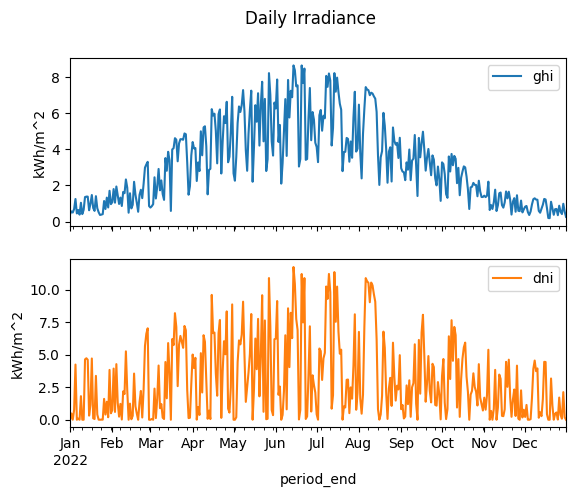

In [6]:
# plot up the results
dates = (df.index - pd.Timedelta(hours=1)).floor("1d")
(df.groupby(dates).sum() / 1000).plot(subplots=True, title="Daily Irradiance", ylabel="kWh/m^2")
